# Surface tension using PC-SAFT Helmholtz energy functionals

## Goal of this notebook

- Learn how to compute the surface tension for a planar interface using the PC-SAFT functionals.
- Learn about the `SurfaceTensionDiagram` that allows convenient calculation of multiple surface tensions.

In [1]:
from feos.pcsaft import *
from feos.dft import *

import si_units as si
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context("talk")
sns.set_palette("Dark2")
sns.set_style("ticks")

colors = sns.color_palette("Dark2", 2)

### Water parameters for PC-SAFT 

In this example we will calculate surface tensions for water using the 2B association scheme. The parameters that we use, [were adjusted to vapor pressures, liquid densities and surface tensions](https://pubs.acs.org/doi/10.1021/acs.jced.0c00684). Parameters are available [here](https://github.com/feos-org/feos/tree/main/parameters/pcsaft).

In [2]:
# Equation of state object.
parameters = PcSaftParameters.from_json(
    ['water_2B'], 
    '../parameters/pcsaft/rehner2020.json'
)
pcsaft = HelmholtzEnergyFunctional.pcsaft(parameters)

Let's first compute the critical point. We will make use of the critical temperature later.

In [3]:
cp = State.critical_point(pcsaft)
cp

|temperature|density|
|-|-|
|677.34347 K|18.70466 kmol/m³|

As you can see, the model overestimates the critical temperature.

## Surface tension for single VLE

To compute the surface tension, three steps are needed.

1. We need to compute the vapor liquid equilibrium (VLE) either at given temperature or pressure.
2. Then, we need to initialize a density profile. We will use a hyperbolic tangent with the VLE bulk densities as limits.
3. We solve the DFT equations to yield the equilibrium density profile and calculate the surface tension.

For the VLE, we use the `PhaseEquilibrium.pure` method. Here for $T = 300$ Kelvin.

In [4]:
vle = PhaseEquilibrium.pure(pcsaft, 300*si.KELVIN)
vle

||temperature|density|
|-|-|-|
|phase 1|300.00000 K|1.51670  mol/m³|
|phase 2|300.00000 K|55.38975 kmol/m³|


Next, we initialize the density profile. For the surface tension, a 1D DFT calculation in Cartesian coordinates is conducted. Thus, the density profile will be an 1D array (we have a single substance). 

To solve the DFT equations, the density has to be discretized which can be controlled by `n_grid`, the number of grid points. The surface tension is not very sensitive w.r.t the number of grid points but you should make sure to pick a large enough value. When in doubt, run multiple calculations varying the number.

We also have to provide a width of the calculation domain, `l_grid`. The domain should be large enough that the bulk densities can be observed in the limits. You can check the resulting density profile to make sure that's the case.

The critical temperature is used to come up with a good initial estimate for the density profile.

In [5]:
%%time
interface = PlanarInterface.from_tanh(
    vle=vle, 
    n_grid=512, 
    l_grid=100*si.ANGSTROM, 
    critical_temperature=cp.temperature
)
initial_density = interface.density / (si.KILO * si.MOL / si.METER**3)

CPU times: user 562 µs, sys: 19 µs, total: 581 µs
Wall time: 583 µs


The above method does not yet run a calculation. If we try to extract the surface tension, it will return `None`. Let's store the initial density profile for a later comparison.

In [6]:
interface.surface_tension == None

True

To calculate the equilibrium density profile, we have to call the `solve()` method:

In [7]:
%%time
surface_tension = interface.solve().surface_tension

CPU times: user 28.6 ms, sys: 24 µs, total: 28.6 ms
Wall time: 28.5 ms


`solve()` calculates the equilibrium density profile and returns the `PlanarInterface` object so that we can readily extract the `surface_tension`.

The `PlanarInterface.density` contains the equilibrated density profile. Let's compare it to our initial density and zoom into the interesting region between 40 and 60 Angstrom. 

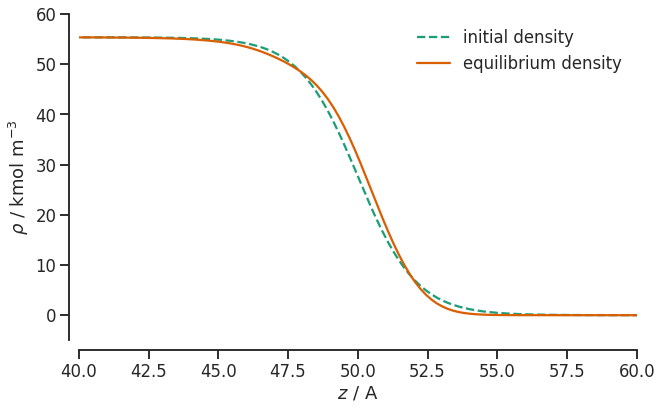

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(interface.z / si.ANGSTROM, initial_density[0], linestyle="dashed", label="initial density")
plt.plot(interface.z / si.ANGSTROM, (interface.density / (si.KILO * si.MOL / si.METER**3))[0], label="equilibrium density")

plt.xlim(40, 60)
plt.ylim(-5, 60)
plt.ylabel(r"$\rho$ / kmol m$^{-3}$")
plt.xlabel(r"$z$ / A")
sns.despine(offset=10)
plt.legend(frameon=False);

## Comparison to NIST data using `SurfaceTensionDiagram`

We can use the above steps to calculate multiple VLE's and then - for each VLE - calculate the surface tension. We provide a utility object, the `SurfaceTensionDiagram`, that you can use to do exactly this task. Let's load some experimental (correlation) data obtained from the NIST Webbook and see how the water model compares to that.

In [9]:
literature = pd.read_csv("data/water_vle_nist.csv", delimiter="\t")
literature.head()

,Temperature (K),Pressure (MPa),"Density (l, mol/l)","Volume (l, l/mol)","Internal Energy (l, kJ/mol)","Enthalpy (l, kJ/mol)","Entropy (l, J/mol*K)","Cv (l, J/mol*K)","Cp (l, J/mol*K)","Sound Spd. (l, m/s)",...,"Volume (v, l/mol)","Internal Energy (v, kJ/mol)","Enthalpy (v, kJ/mol)","Entropy (v, J/mol*K)","Cv (v, J/mol*K)","Cp (v, J/mol*K)","Sound Spd. (v, m/s)","Joule-Thomson (v, K/MPa)","Viscosity (v, uPa*s)","Therm. Cond. (v, W/m*K)"
0,275.0,0.000698,55.502,0.018017,0.13978,0.13979,0.5100,75.903,75.915,1411.4,...,3271.50,42.830,45.115,164.06,25.580,33.980,410.33,558.89,8.9986,0.016879
1,285.0,0.001389,55.479,0.018025,0.89678,0.89681,3.2139,75.397,75.533,1454.3,...,1704.30,43.078,45.445,159.52,25.736,34.170,417.48,408.81,9.2941,0.017535
2,295.0,0.002621,55.384,0.018056,1.65110,1.65120,5.8154,74.765,75.361,1487.7,...,934.36,43.324,45.773,155.38,25.898,34.374,424.46,304.01,9.6018,0.018214
3,305.0,0.004719,55.233,0.018105,2.40440,2.40440,8.3264,74.038,75.300,1513.1,...,536.20,43.568,46.099,151.59,26.069,34.596,431.28,231.32,9.9196,0.018918
4,315.0,0.008145,55.034,0.018171,3.15730,3.15750,10.7560,73.235,75.301,1531.7,...,320.58,43.811,46.422,148.10,26.252,34.843,437.93,180.66,10.2460,0.019646


For the `SurfaceTensionDiagram`, we need to provide the VLE's. We compute those using the `PhaseDiagram` object (here for 50 temperatures between 275 Kelvin and the critical temperature) from which we get a list of `PhaseEquilibrium`s via the `states` filed. The `SurfaceTensionDiagram` is nice, because we can reuse equilibrium density profiles from prior iterations as input for the next iteration. It's therefore typically faster and more stable than an "naive" implementation by hand.

The `SurfaceTensionDiagram` takes the same arguments `n_grind`, `l_grid` and `critical_temperature` as discussed above.

In [10]:
%%time
vles = PhaseDiagram.pure(
    pcsaft, 
    275*si.KELVIN, 
    50,
    critical_temperature=cp.temperature
)
sfts = SurfaceTensionDiagram(
    vles.states, 
    n_grid=512, 
    l_grid=100*si.ANGSTROM, 
    critical_temperature=cp.temperature
)

CPU times: user 608 ms, sys: 0 ns, total: 608 ms
Wall time: 606 ms


We now can extract all surface tensions via `surface_tension` as well as the liquid and vapor states via the `liquid` and `vapor` getters, respectively. Let's store the results in a pandas `DataFrame` to make plotting easier.

In [11]:
dft_data = pd.DataFrame(
    np.array([
        sfts.liquid.temperature / si.KELVIN, 
        sfts.surface_tension / si.NEWTON * si.METER
    ]).T, 
    columns=["Temperature (K)", "Surf. Tension (l, N/m)"]
)

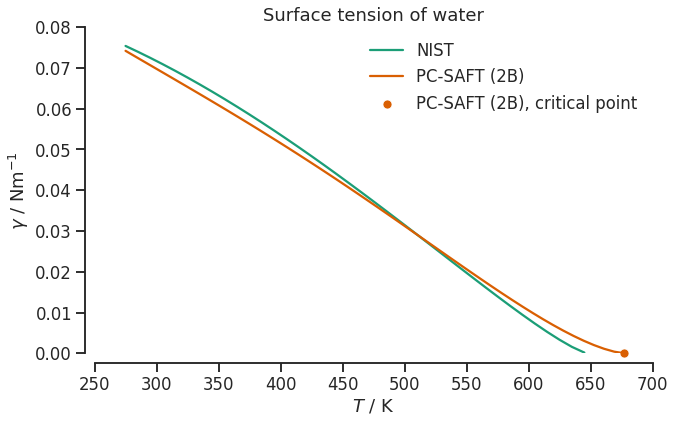

In [12]:
plt.figure(figsize=(10, 6))
plt.title("Surface tension of water")
sns.lineplot(data=literature, x="Temperature (K)", y="Surf. Tension (l, N/m)", label="NIST")
sns.lineplot(data=dft_data, x="Temperature (K)", y="Surf. Tension (l, N/m)", label="PC-SAFT (2B)")
sns.scatterplot(x=[cp.temperature / si.KELVIN], y=[0.0], clip_on=False, color=colors[1], label="PC-SAFT (2B), critical point")
plt.ylabel(r"$\gamma$ / Nm$^{-1}$")
plt.xlabel(r"$T$ / K")

plt.xlim(250, 700)
plt.ylim(0.0, 0.08)
sns.despine(offset=10)
plt.legend(frameon=False);

## Concluding remkars

Hopefully you found this example helpful. If you have comments, critique or feedback, please let us know and consider [opening an issue on github](https://github.com/feos-org/feos/issues).